<a href="https://colab.research.google.com/github/Brites101/bazicodes/blob/master/GraphQL_ogt_application_count_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import requests
import pandas as pd
from pandas.io.json import json_normalize
import pandas.io.json as pd_json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style


!pip install gql -q

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# EXPA Token request

Access [token generator](http://token.aiesec.org.br/get_token.php?token=c0aa46e01d77fb212fe0195636fb515f8e43b530087399ec49f) and paste the token below

In [0]:
  token_get_url = "http://token.aiesec.org.br/get_token.php?token=c0aa46e01d77fb212fe0195636fb515f8e43b530087399ec49f"
  access_token = requests.get(token_get_url)
  print(access_token.text.strip())

# GraphQL Query

In [0]:
#calls a query from the GraphQL API

_transport = RequestsHTTPTransport(
    url='https://gis-api.aiesec.org/graphql?access_token='+str(access_token.text.strip()),
    use_json=True,
)


client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)
#Here you insert the query
query = gql("""
{
  allOpportunityApplication(filters: {created_at: {from:"2019-01-01T22:00:00Z", to:"2019-07-01T22:00:00Z"}, programmes:2, person_home_mc: 1606},per_page:4000, page: 1) 
  {
    data {
      person {
        id
        status
        opportunity_applications_count        
              } 
         }
  }
}
""")

query_json=client.execute(query)

In [0]:
print(query_json)

In [0]:
#Flatten JSON into a dataframe
query_df = json_normalize(query_json['allOpportunityApplication']['data'])

In [0]:
print(query_df)

In [0]:
#Remove entries with more than 700 applications
query_df = query_df[query_df["person.opportunity_applications_count"] < 700]

In [0]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# Application count distribution per customer flow stage

Text(0.5, 0, "Applicant's Latest Status")

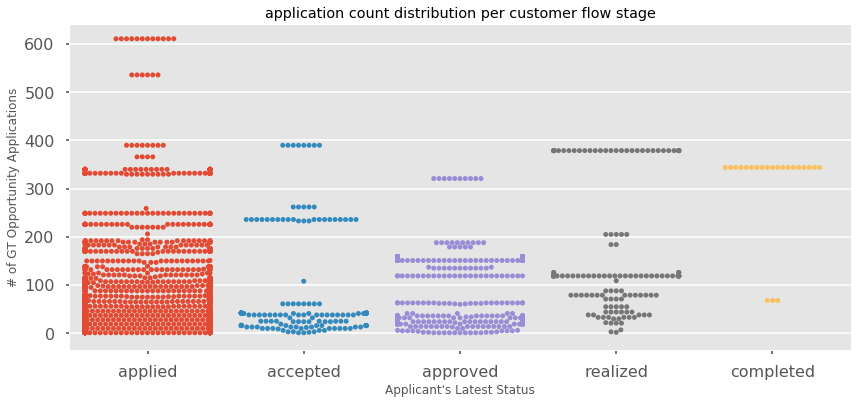

In [0]:

plt.figure(figsize=(14,6))

plt.title("application count distribution per customer flow stage")



sns.swarmplot(x=query_df['person.status'],
              y=query_df['person.opportunity_applications_count'],
              order=["applied", "accepted", "approved", "realized", "completed"])

plt.ylabel("# of GT Opportunity Applications")

plt.xlabel("Applicant's Latest Status")

# Average GT application count per stage

Text(0.5, 0, "Applicant's Latest Status")

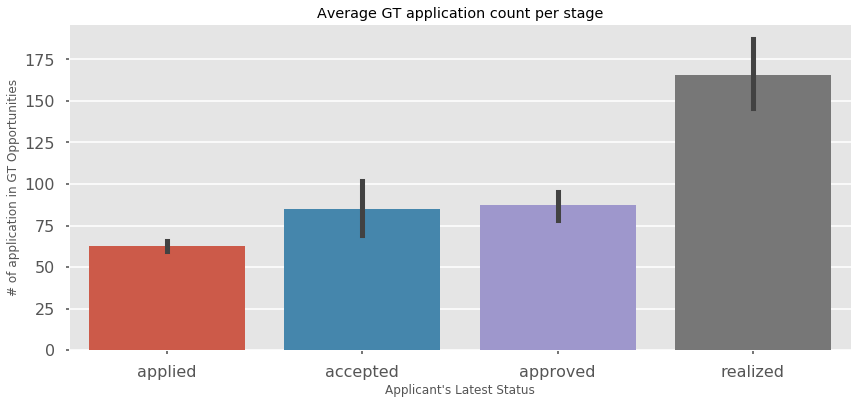

In [0]:
plt.figure(figsize=(14,6))

plt.title("Average GT application count per stage")


sns.barplot(x=query_df['person.status'],
              y=query_df['person.opportunity_applications_count'],
              order=["applied", "accepted", "approved", "realized"])

plt.ylabel("# of application in GT Opportunities")

plt.xlabel("Applicant's Latest Status")

# Distribution

Text(0.5, 0, 'People Application count')

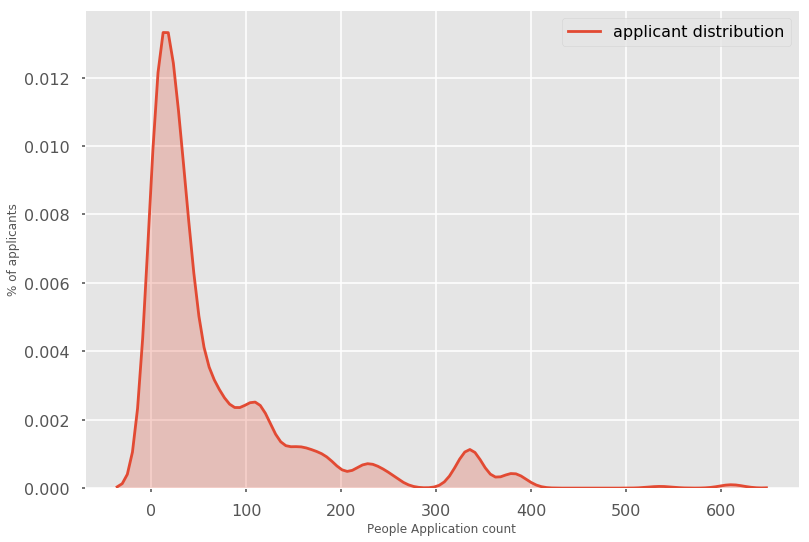

In [0]:
plt.figure(figsize=(14,6))

plt.title("applicant distribution per application count")

sns.kdeplot(data=query_df['person.opportunity_applications_count'],label="applicant distribution", shade=True)

plt.ylabel("% of applicants")

plt.xlabel("People Application count")

# Distribution comparison between applied and the rest of the customer flow

In [0]:
applied_query_df = query_df[query_df["person.status"] == "applied"]
accepted_query_df = query_df[query_df["person.status"] == "accepted"]
approved_query_df = query_df[query_df["person.status"] == "approved"]
realized_query_df = query_df[query_df["person.status"] == "realized"]
completed_query_df = query_df[query_df["person.status"] == "completed"]


#very inefficient format below. Boolean operators didnt work to set multiple conditions in a single statement
accepted_beyond_query_df = query_df[query_df["person.status"] != "applied"]
accepted_beyond_query_df = accepted_beyond_query_df[accepted_beyond_query_df["person.status"] != "completed"]
accepted_beyond_query_df = accepted_beyond_query_df[accepted_beyond_query_df["person.status"] != "deleted"]


Text(0.5, 0, 'People Application count')

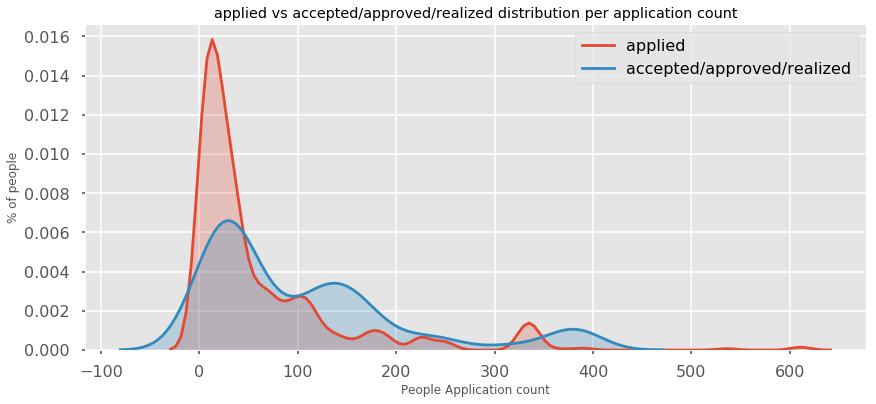

In [0]:
plt.figure(figsize=(14,6))

plt.title("applied vs accepted/approved/realized distribution per application count")

sns.kdeplot(data=applied_query_df['person.opportunity_applications_count'], label="applied", shade=True)
sns.kdeplot(data=accepted_beyond_query_df['person.opportunity_applications_count'], label="accepted/approved/realized", shade=True)

plt.ylabel("% of people")

plt.xlabel("People Application count")